## Get Data

In [1]:
from IPython.display import clear_output
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d jackstapleton/petfinder-pf-nc-ua-all-dataset

!mkdir ~/.data
!unzip -q petfinder-pf-nc-ua-all-dataset.zip -d /.data

clear_output()

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

clear_output()

## Library Imports

In [3]:
import os
import gc
import re
import pickle
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torchvision import models, transforms

from time import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Constants and Utilities

In [4]:
SEED = 49
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "/.data"

verbose = True
DEBUG = False

# sc_y = StandardScaler()
ohe = OneHotEncoder()

In [5]:
def breaker(num=50, char="*") -> None:
    print("\n" + num*char + "\n")


def get_targets() -> np.ndarray:
    df = pd.read_csv("/content/gdrive/My Drive/train.csv", engine="python")
    targets = df["Pawpularity"].copy().values
    oh_targets = targets.copy()
    oh_targets = ohe.fit_transform(oh_targets.reshape(-1, 1))
    oh_targets = oh_targets.todense()
    return targets, oh_targets


def show_graphs(L: list, title=None) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(L) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="train")
    plt.plot(x_Axis, VL, "b", label="valid")
    plt.grid()
    plt.legend()
    if title:
        plt.title("{} Loss".format(title))
    else:
        plt.title("Loss")
    plt.show()

## Dataset Template and BuildDataloader

In [6]:
class DS(Dataset):
    def __init__(self, features=None, targets=None):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.FloatTensor(self.targets[idx])
    

def build_dataloaders(tr_features: np.ndarray, va_features: np.ndarray,
                      tr_targets: np.ndarray, va_targets: np.ndarray,
                      batch_size: int, seed: int):

    if verbose:
        breaker()
        print("Building Train and Validation DataLoaders ...")
    
    tr_data_setup = DS(features=tr_features, targets=tr_targets)
    va_data_setup = DS(features=va_features, targets=va_targets)
    
    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(seed)),
        "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False)
    }
    
    return dataloaders

## Build Model

In [7]:
def build_model(IL: int, seed: int):
    class ANN(nn.Module):
        def __init__(self, IL=None):
            super(ANN, self).__init__()

            self.classifier = nn.Sequential()
            self.classifier.add_module("BN", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            self.classifier.add_module("FC", WN(nn.Linear(in_features=IL, out_features=100)))

        def get_optimizer(self, lr=1e-3, wd=0):
            params = [p for p in self.parameters() if p.requires_grad]
            return optim.Adam(params, lr=lr, weight_decay=wd)

        def get_plateau_scheduler(self, optimizer=None, patience=5, eps=1e-8):
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)

        def forward(self, x1, x2=None):
            if x2 is not None:
                return self.classifier(x1), self.classifier(x2)
            else:
                return self.classifier(x1)
    
    if verbose:
        breaker()
        print("Building Model ...")
        print("\n{} -> 1".format(IL))
    
    torch.manual_seed(seed)
    model = ANN(IL=IL)
    
    return model

## Fit and Predict Helpers

In [8]:
def fit(model=None, optimizer=None, scheduler=None, 
        epochs=None, early_stopping_patience=None,
        dataloaders=None, fold=None, verbose=False) -> tuple:
    
    name = "./Fold_{}_state.pt".format(fold)
    
    if verbose:
        breaker()
        print("Training Fold {}...".format(fold))
        breaker()
    else:
        print("Training Fold {}...".format(fold))

    Losses = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : np.inf, "valid" : np.inf}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass = []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.BCEWithLogitsLoss()(output, y.squeeze(dim=1))
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        Losses.append(epochLoss)

        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           name)
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    if verbose:
                        print("\nEarly Stopping at Epoch {}".format(e))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict": model.state_dict(),
                        "optim_state_dict": optimizer.state_dict()},
                       name)
        
        if scheduler:
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
    
    if verbose:
        breaker()
        print("Best Validation Loss at Epoch {}".format(BLE))
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
        breaker()
        print("Training Completed")
        breaker()

    return Losses, BLE, name

#####################################################################################################

def predict_batch(model=None, dataloader=None, mode="test", path=None) -> np.ndarray:    
    model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
    model.to(DEVICE)
    model.eval()

    y_pred = torch.zeros(1, 1).to(DEVICE)

    if re.match(r"valid", mode, re.IGNORECASE):
        for X, _ in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = torch.argmax(model(X), dim=1)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)

    elif re.match(r"test", mode, re.IGNORECASE):
        for X in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
               output = torch.argmax(model(X), dim=1)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    y_pred = y_pred[1:].detach().cpu().numpy()
    y_pred = y_pred + 1
    return y_pred

## Train

In [9]:
def train(features: np.ndarray, targets: np.ndarray, oh_targets: np.ndarray,
          n_splits: int, batch_size: int, lr: float, wd: float, 
          epochs: int, early_stopping: int, 
          patience=None, eps=None) -> list:        
    
    metrics = []
        
    KFold_start_time = time()
    breaker()
    print("Performing {} Fold CV ...".format(n_splits))
    if verbose:
        pass
    else:
        breaker()
    fold = 1
    for tr_idx, va_idx in KFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(features):

        tr_features, va_features = features[tr_idx], features[va_idx]
        tr_targets, va_targets = targets[tr_idx], targets[va_idx]
        oh_tr_targets, oh_va_targets = oh_targets[tr_idx], oh_targets[va_idx]


        dataloaders = build_dataloaders(tr_features, va_features,
                                        oh_tr_targets, oh_va_targets, 
                                        batch_size, SEED)
        model = build_model(IL=tr_features.shape[1], seed=SEED).to(DEVICE)
        optimizer = model.get_optimizer(lr=lr, wd=wd)
        scheduler = None
        if isinstance(patience, int) and isinstance(eps, float):
            scheduler = model.get_plateau_scheduler(optimizer, patience, eps)

        L, _, name = fit(model=model, optimizer=optimizer, scheduler=scheduler, 
                         epochs=epochs, early_stopping_patience=early_stopping,
                         dataloaders=dataloaders, fold=fold, verbose=verbose)
        y_pred = predict_batch(model=model, dataloader=dataloaders["valid"], mode="valid", path=name)
        RMSE = np.sqrt(mean_squared_error(y_pred, va_targets))
        if verbose:
            print("Validation RMSE [Fold {}]: {:.5f}".format(fold, RMSE))
            breaker()
            show_graphs(L)
        
        metrics_dict = {"Fold" : fold, "RMSE" : RMSE}
        metrics.append(metrics_dict)
        
        fold += 1

    breaker()
    print("Total Time to {} Fold CV : {:.2f} minutes".format(n_splits, (time() - KFold_start_time)/60))
    breaker()

    return metrics, (time() - KFold_start_time)/60

## Main


In [10]:
def main():
    breaker()
    print("Clean Memory , {} Objects Collected ...".format(gc.collect()))

    ########### Params ###########
    
    if DEBUG:
        n_splits = 3
        patience, eps = 5, 1e-8
        epochs, early_stopping = 5, 5

        batch_size = 128
        lr = 1e-3
        wd = 1e-1
    else:
        n_splits = 10
        patience, eps = 5, 1e-8
        epochs, early_stopping = 1000, 50

        batch_size = 128
        lr = 1e-6
        wd = 1e-5
    
    ##############################

    if verbose:
        breaker()
        print("Loading Data ...")
    
    features = np.load(os.path.join(PATH, "densenet169_features.npy"))
    targets, oh_targets = get_targets()

    # Without Scheduler
    metrics, _ = train(features, targets, oh_targets, n_splits, batch_size, lr, wd, epochs, early_stopping, patience=None, eps=None)

    # With Scheduler
    # train(images, targets, n_splits, batch_size, lr, wd, epochs, early_stopping, pretrained_ann_path, patience=patience, eps=eps)

    if verbose:
        pass
    else:
        breaker()
    rmse = []
    for i in range(len(metrics)):
        print("Fold {}, RMSE {:.5f}".format(metrics[i]["Fold"], metrics[i]["RMSE"]))
        rmse.append(metrics[i]["RMSE"])
    breaker()

    best_index = rmse.index(min(rmse))

    print("Best RMSE : {:.5f}".format(metrics[best_index]["RMSE"]))
    print("Avg RMSE  : {:.5f}".format(sum(rmse) / len(rmse)))

    with open("metrics.pkl", "wb") as fp:
        pickle.dump(metrics, fp)

    breaker()


**************************************************

Clean Memory , 152 Objects Collected ...

**************************************************

Loading Data ...

**************************************************

Performing 10 Fold CV ...

**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 1...

**************************************************

Epoch: 1 | Train Loss: 0.71488 | Valid Loss: 0.71176 | Time: 0.72 seconds
Epoch: 2 | Train Loss: 0.71435 | Valid Loss: 0.71386 | Time: 0.45 seconds
Epoch: 3 | Train Loss: 0.71381 | Valid Loss: 0.71406 | Time: 0.44 seconds
Epoch: 4 | Train Loss: 0.71332 | Valid Loss: 0.71255 | Time: 0.44 seconds
Epoch: 5 | Train Loss: 0.71283 | Valid Loss: 0.71209 | Time: 0.45 seconds
Epoch: 6 | Train Loss: 0.71236 | Valid Loss: 0.71172 | Time: 0.45 seconds
Epoch:

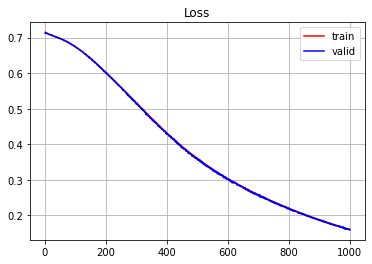


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 2...

**************************************************

Epoch: 1 | Train Loss: 0.71491 | Valid Loss: 0.71196 | Time: 0.45 seconds
Epoch: 2 | Train Loss: 0.71436 | Valid Loss: 0.71401 | Time: 0.45 seconds
Epoch: 3 | Train Loss: 0.71383 | Valid Loss: 0.71449 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.71332 | Valid Loss: 0.71337 | Time: 0.46 seconds
Epoch: 5 | Train Loss: 0.71285 | Valid Loss: 0.71277 | Time: 0.46 seconds
Epoch: 6 | Train Loss: 0.71238 | Valid Loss: 0.71254 | Time: 0.45 seconds
Epoch: 7 | Train Loss: 0.71193 | Valid Loss: 0.71231 | Time: 0.45 seconds
Epoch: 8 | Train Loss: 0.71150 | Valid Loss: 0.71150 | Time: 0.47 seconds
Epoch: 9 | Train Loss: 0.71111 | Valid Loss: 0.71121 | Time: 0.46 seconds
Epoch: 10 | Train Loss: 0.7

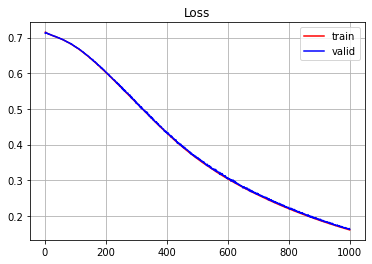


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 3...

**************************************************

Epoch: 1 | Train Loss: 0.71490 | Valid Loss: 0.71110 | Time: 0.47 seconds
Epoch: 2 | Train Loss: 0.71435 | Valid Loss: 0.71248 | Time: 0.46 seconds
Epoch: 3 | Train Loss: 0.71384 | Valid Loss: 0.71310 | Time: 0.48 seconds
Epoch: 4 | Train Loss: 0.71333 | Valid Loss: 0.71277 | Time: 0.44 seconds
Epoch: 5 | Train Loss: 0.71286 | Valid Loss: 0.71108 | Time: 0.46 seconds
Epoch: 6 | Train Loss: 0.71239 | Valid Loss: 0.71094 | Time: 0.46 seconds
Epoch: 7 | Train Loss: 0.71194 | Valid Loss: 0.71100 | Time: 0.44 seconds
Epoch: 8 | Train Loss: 0.71152 | Valid Loss: 0.71041 | Time: 0.47 seconds
Epoch: 9 | Train Loss: 0.71109 | Valid Loss: 0.70978 | Time: 0.46 seconds
Epoch: 10 | Train Loss: 0.7

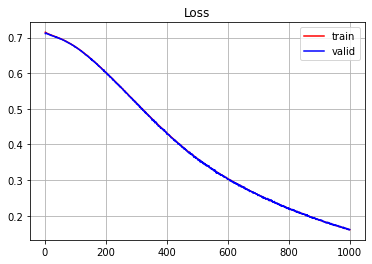


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 4...

**************************************************

Epoch: 1 | Train Loss: 0.71485 | Valid Loss: 0.71275 | Time: 0.48 seconds
Epoch: 2 | Train Loss: 0.71431 | Valid Loss: 0.71492 | Time: 0.46 seconds
Epoch: 3 | Train Loss: 0.71378 | Valid Loss: 0.71389 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.71329 | Valid Loss: 0.71369 | Time: 0.46 seconds
Epoch: 5 | Train Loss: 0.71281 | Valid Loss: 0.71351 | Time: 0.45 seconds
Epoch: 6 | Train Loss: 0.71235 | Valid Loss: 0.71306 | Time: 0.45 seconds
Epoch: 7 | Train Loss: 0.71190 | Valid Loss: 0.71303 | Time: 0.45 seconds
Epoch: 8 | Train Loss: 0.71147 | Valid Loss: 0.71234 | Time: 0.49 seconds
Epoch: 9 | Train Loss: 0.71105 | Valid Loss: 0.71143 | Time: 0.47 seconds
Epoch: 10 | Train Loss: 0.7

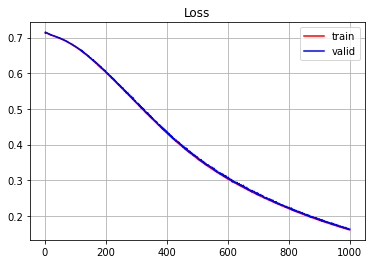


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 5...

**************************************************

Epoch: 1 | Train Loss: 0.71488 | Valid Loss: 0.71144 | Time: 0.49 seconds
Epoch: 2 | Train Loss: 0.71432 | Valid Loss: 0.71334 | Time: 0.45 seconds
Epoch: 3 | Train Loss: 0.71380 | Valid Loss: 0.71344 | Time: 0.49 seconds
Epoch: 4 | Train Loss: 0.71331 | Valid Loss: 0.71315 | Time: 0.47 seconds
Epoch: 5 | Train Loss: 0.71283 | Valid Loss: 0.71267 | Time: 0.47 seconds
Epoch: 6 | Train Loss: 0.71236 | Valid Loss: 0.71178 | Time: 0.47 seconds
Epoch: 7 | Train Loss: 0.71191 | Valid Loss: 0.71179 | Time: 0.45 seconds
Epoch: 8 | Train Loss: 0.71149 | Valid Loss: 0.71168 | Time: 0.47 seconds
Epoch: 9 | Train Loss: 0.71107 | Valid Loss: 0.71077 | Time: 0.46 seconds
Epoch: 10 | Train Loss: 0.7

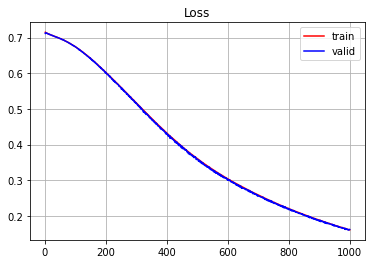


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 6...

**************************************************

Epoch: 1 | Train Loss: 0.71486 | Valid Loss: 0.71130 | Time: 0.48 seconds
Epoch: 2 | Train Loss: 0.71431 | Valid Loss: 0.71328 | Time: 0.48 seconds
Epoch: 3 | Train Loss: 0.71381 | Valid Loss: 0.71301 | Time: 0.46 seconds
Epoch: 4 | Train Loss: 0.71329 | Valid Loss: 0.71227 | Time: 0.46 seconds
Epoch: 5 | Train Loss: 0.71281 | Valid Loss: 0.71232 | Time: 0.46 seconds
Epoch: 6 | Train Loss: 0.71234 | Valid Loss: 0.71144 | Time: 0.47 seconds
Epoch: 7 | Train Loss: 0.71191 | Valid Loss: 0.71153 | Time: 0.48 seconds
Epoch: 8 | Train Loss: 0.71149 | Valid Loss: 0.71081 | Time: 0.46 seconds
Epoch: 9 | Train Loss: 0.71107 | Valid Loss: 0.71075 | Time: 0.47 seconds
Epoch: 10 | Train Loss: 0.7

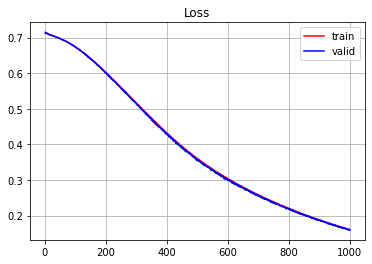


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 7...

**************************************************

Epoch: 1 | Train Loss: 0.71484 | Valid Loss: 0.71223 | Time: 0.48 seconds
Epoch: 2 | Train Loss: 0.71430 | Valid Loss: 0.71505 | Time: 0.49 seconds
Epoch: 3 | Train Loss: 0.71377 | Valid Loss: 0.71384 | Time: 0.46 seconds
Epoch: 4 | Train Loss: 0.71329 | Valid Loss: 0.71452 | Time: 0.47 seconds
Epoch: 5 | Train Loss: 0.71278 | Valid Loss: 0.71290 | Time: 0.46 seconds
Epoch: 6 | Train Loss: 0.71233 | Valid Loss: 0.71242 | Time: 0.50 seconds
Epoch: 7 | Train Loss: 0.71187 | Valid Loss: 0.71286 | Time: 0.46 seconds
Epoch: 8 | Train Loss: 0.71146 | Valid Loss: 0.71172 | Time: 0.48 seconds
Epoch: 9 | Train Loss: 0.71104 | Valid Loss: 0.71079 | Time: 0.47 seconds
Epoch: 10 | Train Loss: 0.7

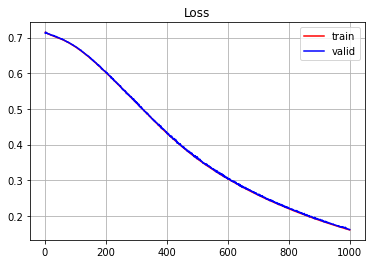


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 8...

**************************************************

Epoch: 1 | Train Loss: 0.71492 | Valid Loss: 0.71269 | Time: 0.47 seconds
Epoch: 2 | Train Loss: 0.71435 | Valid Loss: 0.71446 | Time: 0.47 seconds
Epoch: 3 | Train Loss: 0.71383 | Valid Loss: 0.71366 | Time: 0.46 seconds
Epoch: 4 | Train Loss: 0.71333 | Valid Loss: 0.71368 | Time: 0.46 seconds
Epoch: 5 | Train Loss: 0.71285 | Valid Loss: 0.71343 | Time: 0.45 seconds
Epoch: 6 | Train Loss: 0.71239 | Valid Loss: 0.71306 | Time: 0.46 seconds
Epoch: 7 | Train Loss: 0.71192 | Valid Loss: 0.71311 | Time: 0.46 seconds
Epoch: 8 | Train Loss: 0.71150 | Valid Loss: 0.71217 | Time: 0.47 seconds
Epoch: 9 | Train Loss: 0.71108 | Valid Loss: 0.71176 | Time: 0.45 seconds
Epoch: 10 | Train Loss: 0.7

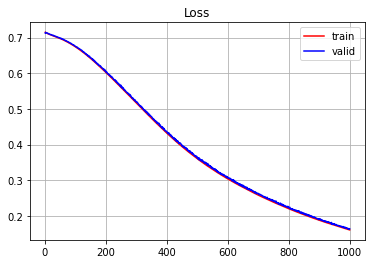


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 9...

**************************************************

Epoch: 1 | Train Loss: 0.71488 | Valid Loss: 0.71185 | Time: 0.52 seconds
Epoch: 2 | Train Loss: 0.71432 | Valid Loss: 0.71449 | Time: 0.47 seconds
Epoch: 3 | Train Loss: 0.71381 | Valid Loss: 0.71348 | Time: 0.48 seconds
Epoch: 4 | Train Loss: 0.71331 | Valid Loss: 0.71297 | Time: 0.48 seconds
Epoch: 5 | Train Loss: 0.71283 | Valid Loss: 0.71266 | Time: 0.49 seconds
Epoch: 6 | Train Loss: 0.71236 | Valid Loss: 0.71223 | Time: 0.47 seconds
Epoch: 7 | Train Loss: 0.71192 | Valid Loss: 0.71167 | Time: 0.49 seconds
Epoch: 8 | Train Loss: 0.71148 | Valid Loss: 0.71184 | Time: 0.48 seconds
Epoch: 9 | Train Loss: 0.71106 | Valid Loss: 0.71023 | Time: 0.48 seconds
Epoch: 10 | Train Loss: 0.7

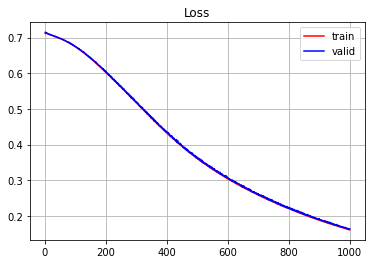


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

1664 -> 1

**************************************************

Training Fold 10...

**************************************************

Epoch: 1 | Train Loss: 0.71488 | Valid Loss: 0.71236 | Time: 0.48 seconds
Epoch: 2 | Train Loss: 0.71432 | Valid Loss: 0.71337 | Time: 0.46 seconds
Epoch: 3 | Train Loss: 0.71380 | Valid Loss: 0.71292 | Time: 0.47 seconds
Epoch: 4 | Train Loss: 0.71330 | Valid Loss: 0.71291 | Time: 0.46 seconds
Epoch: 5 | Train Loss: 0.71281 | Valid Loss: 0.71325 | Time: 0.47 seconds
Epoch: 6 | Train Loss: 0.71237 | Valid Loss: 0.71192 | Time: 0.47 seconds
Epoch: 7 | Train Loss: 0.71191 | Valid Loss: 0.71203 | Time: 0.47 seconds
Epoch: 8 | Train Loss: 0.71147 | Valid Loss: 0.71131 | Time: 0.47 seconds
Epoch: 9 | Train Loss: 0.71106 | Valid Loss: 0.71148 | Time: 0.47 seconds
Epoch: 10 | Train Loss: 0.

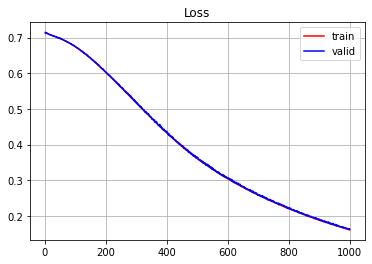


**************************************************

Total Time to 10 Fold CV : 78.39 minutes

**************************************************

Fold 1, RMSE 32.77649
Fold 2, RMSE 33.05209
Fold 3, RMSE 33.37374
Fold 4, RMSE 32.20404
Fold 5, RMSE 34.59102
Fold 6, RMSE 31.66981
Fold 7, RMSE 32.94501
Fold 8, RMSE 31.94207
Fold 9, RMSE 30.99997
Fold 10, RMSE 30.55930

**************************************************

Best RMSE : 30.55930
Avg RMSE  : 32.41135

**************************************************



In [11]:
main()